In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns
from datetime import timedelta
import matplotlib.ticker as tkr
from sklearn.cluster import KMeans

def custom_grouping(index):
    return index // 1000

names_latency=['submission_time', 'duration', 'op2', 'write_size', 'op3']
columns = ['submission_time', 'duration', 'write_size']

# Step 1: Read the CSV file into a Pandas DataFrame
#df = pd.read_csv(f'/home/surbhi/measurements/worst_case/STL/1M/90-10-LBA/90Util/run1/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)

In [17]:
df1 = pd.read_csv('/home/surbhi/measurements/STL/cache/uniform-random/run1/lat_log_avg_lat.1.log', sep=',', names=names_latency, usecols=columns)
# Convert nanoseconds to microseconds for the 'time' column
df1['duration'] = df1['duration'] / 1000000  # Convert nanoseconds to milliseconds
# Calculate cumulative GBs of data written
df1['cumulative_gb'] = np.floor(df1['write_size'].cumsum() / (1024**3))
df1['submission_time'] = df1['submission_time'] - df1.iloc[0].submission_time
df1['completion_time'] = np.floor(df1['submission_time'] + df1['duration'])

In [18]:
# Step 3: Determine the start and end time of the entire test
start_time = int(df1['submission_time'].min())
end_time = int(math.ceil(df1['completion_time'].max()))


# Step 4: Create new DataFrames to represent each  millisecond between the start and end time of the entire test
data_written_ms1 = pd.DataFrame(index=range(start_time, end_time + 1, 1), columns=['data_written_bytes'])
data_written_ms1['data_written_bytes'] = 0

# Step 5: Iterate through each write request, calculate the data size for each time interval, and update the corresponding entries in the DataFrames
for index, row in df1.iterrows():
    duration = row['duration']
    start = int(row['submission_time'])
    end = start+math.floor(duration)
    
    payload = 1048576
    write_rate_per_ms = payload / max(duration, 1.)
    assert(write_rate_per_ms <= payload)
    residue = payload - write_rate_per_ms * math.floor(duration)
    assert (payload >= (write_rate_per_ms * math.floor(duration)))
    data_written_ms1.loc[start:end-1] += write_rate_per_ms
    # residue could be zero when last == end
    data_written_ms1.loc[end] += residue

print(index)
data_written_ms1.reset_index(drop=True, inplace=True)
last_non_zero_index = data_written_ms1[data_written_ms1.ne(0).any(axis=1)].index[-1]
data_written_ms = data_written_ms1.loc[:last_non_zero_index]

/tmp/ipykernel_18197/507860518.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[464492.28272218 464492.28272218]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_written_ms1.loc[start:end-1] += write_rate_per_ms


35839


In [19]:
chunk_size = 10000
results = []
for i in range(0, len(data_written_ms1), chunk_size):
    chunk = data_written_ms1.iloc[i:i+chunk_size]
    result = chunk.groupby(custom_grouping).sum()
    results.append(result)

df_grouped1 = pd.concat(results)

# Reset the index to make it a regular column
df_grouped1.reset_index(inplace=True)
df_grouped1['cumulative_gb'] = df_grouped1['data_written_bytes'].cumsum() / (1024 ** 3)
df_grouped1['data_written_bytes'] = df_grouped1['data_written_bytes'] / (1024 ** 2) 
df_grouped1.reset_index(drop=True, inplace=True)
last_non_zero_index = df_grouped1[df_grouped1.ne(0).any(axis=1)].index[-1]
df_grouped1 = df_grouped1.loc[:last_non_zero_index]
df_grouped1['latency'] =1 / df_grouped1['data_written_bytes']
#
#data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
print(df_grouped1.describe())
print(df_grouped1.info())


             index  data_written_bytes  cumulative_gb      latency
count  1435.000000         1435.000000    1435.000000  1435.000000
mean    717.000000           24.975610      28.664071          inf
std     414.393131           43.259971       7.506709          NaN
min       0.000000            0.000000       0.098415     0.006916
25%     358.500000            6.089734      28.786984     0.160361
50%     717.000000            6.143461      30.837194     0.162775
75%    1075.500000            6.235916      32.957186     0.164211
max    1434.000000          144.591921      35.000000          inf
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1435 entries, 0 to 1434
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               1435 non-null   int64  
 1   data_written_bytes  1435 non-null   float64
 2   cumulative_gb       1435 non-null   float64
 3   latency             1435 non-null   float

/home/surbhi/.local/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [20]:
df2= pd.read_csv('/home/surbhi/measurements/STL/cache/uniform-random/run2/lat_log_avg_lat.1.log', sep=',' , names=names_latency, usecols=columns)
# Convert nanoseconds to microseconds for the 'time' column
df2['duration'] = df2['duration'] / 1000000  # Convert nanoseconds to milliseconds
# Calculate cumulative GBs of data written
df2['cumulative_gb'] = np.floor(df2['write_size'].cumsum() / (1024**3))
df2['submission_time'] = df2['submission_time'] - df2.iloc[0].submission_time #+ df_grouped1.index.max() + 60 * 60
df2['completion_time'] = np.floor(df2['submission_time'] + df2['duration'])

In [21]:
# Step 3: Determine the start and end time of the entire test
start_time = int(df2['submission_time'].min())
end_time = int(df2['completion_time'].max())

# Step 4: Create new DataFrames to represent each  millisecond between the start and end time of the entire test
data_written_ms2 = pd.DataFrame(index=range(start_time, end_time + 1, 1), columns=['data_written_bytes'])
data_written_ms2['data_written_bytes'] = 0

# Step 5: Iterate through each write request, calculate the data size for each time interval, and update the corresponding entries in the DataFrames
for index, row in df2.iterrows():
    duration = row['duration']
    start = int(row['submission_time'])
    end = start+math.floor(duration)
    
    payload = 1048576
    write_rate_per_ms = payload / max(duration, 1.)
    assert(write_rate_per_ms <= payload)
    residue = payload - write_rate_per_ms * math.floor(duration)
    assert (payload >= (write_rate_per_ms * math.floor(duration)))
    data_written_ms2.loc[start:end-1] += write_rate_per_ms
    # residue could be zero when last == end
    data_written_ms2.loc[end] += residue

print(index)
data_written_ms2.reset_index(drop=True, inplace=True)
last_non_zero_index = data_written_ms2[data_written_ms2.ne(0).any(axis=1)].index[-1]
data_written_ms2 = data_written_ms2.loc[:last_non_zero_index]

/tmp/ipykernel_18197/840144846.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[210.8010519 210.8010519 210.8010519 ... 210.8010519 210.8010519
 210.8010519]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_written_ms2.loc[start:end-1] += write_rate_per_ms


35839


In [22]:
chunk_size = 100000
results = []

for i in range(0, len(data_written_ms2), chunk_size):
    chunk = data_written_ms2.iloc[i:i+chunk_size]
    result = chunk.groupby(custom_grouping).sum()
    results.append(result)

df_grouped2 = pd.concat(results)

# Reset the index to make it a regular column
df_grouped2.reset_index(inplace=True)
df_grouped2['cumulative_gb'] = df_grouped2['data_written_bytes'].cumsum() / (1024 ** 3)
df_grouped2['data_written_bytes'] = df_grouped2['data_written_bytes'] / (1024 ** 2) 
df_grouped2.reset_index(drop=True, inplace=True)
last_non_zero_index = df_grouped2[df_grouped2.ne(0).any(axis=1)].index[-1]
df_grouped2 = df_grouped2.loc[:last_non_zero_index]
df_grouped2['latency'] =1 / df_grouped2['data_written_bytes']
#
#data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
print(df_grouped2.describe())
print(df_grouped2.info())

             index  data_written_bytes  cumulative_gb      latency
count  5008.000000         5008.000000    5008.000000  5008.000000
mean   2503.500000            7.156550      17.441471          inf
std    1445.829404            3.009192      10.207250          NaN
min       0.000000            0.000000       0.005568     0.024067
25%    1251.750000            6.003239       8.588643     0.127164
50%    2503.500000            6.353993      17.453281     0.157381
75%    3755.250000            7.863865      26.308031     0.166577
max    5007.000000           41.551204      35.000000          inf
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               5008 non-null   int64  
 1   data_written_bytes  5008 non-null   float64
 2   cumulative_gb       5008 non-null   float64
 3   latency             5008 non-null   float

/home/surbhi/.local/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [23]:
df3 = pd.read_csv('/home/surbhi/measurements/STL/cache/uniform-random/run4/lat_log_avg_lat.1.log', sep=',', names=names_latency, usecols=columns)
# Convert nanoseconds to microseconds for the 'time' column
df3['duration'] = df3['duration'] / 1000000  # Convert nanoseconds to milliseconds
# Calculate cumulative GBs of data written
df3['cumulative_gb'] = np.floor(df3['write_size'].cumsum() / (1024**3))
df3['submission_time'] = df3['submission_time'] - df3.iloc[0].submission_time
df3['completion_time'] = np.floor(df3['submission_time'] + df3['duration'])

In [24]:
# Step 3: Determine the start and end time of the entire test
start_time = int(df3['submission_time'].min())
end_time = int(df3['completion_time'].max())

# Step 4: Create new DataFrames to represent each  millisecond between the start and end time of the entire test
data_written_ms3 = pd.DataFrame(index=range(start_time, end_time + 1, 1), columns=['data_written_bytes'])
data_written_ms3['data_written_bytes'] = 0

# Step 5: Iterate through each write request, calculate the data size for each time interval, and update the corresponding entries in the DataFrames
for index, row in df3.iterrows():
    duration = row['duration']
    start = int(row['submission_time'])
    end = start+math.floor(duration)
    
    payload = 1048576
    write_rate_per_ms = payload / max(duration, 1.)
    assert(write_rate_per_ms <= payload)
    residue = payload - write_rate_per_ms * math.floor(duration)
    assert (payload >= (write_rate_per_ms * math.floor(duration)))
    data_written_ms3.loc[start:end-1] += write_rate_per_ms
    # residue could be zero when last == end
    data_written_ms3.loc[end] += residue

print(index)
data_written_ms3.reset_index(drop=True, inplace=True)
last_non_zero_index = data_written_ms3[data_written_ms3.ne(0).any(axis=1)].index[-1]
data_written_ms3 = data_written_ms3.loc[:last_non_zero_index]

/tmp/ipykernel_18197/1813428563.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[229999.29809785 229999.29809785 229999.29809785 229999.29809785]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_written_ms3.loc[start:end-1] += write_rate_per_ms


35839


In [25]:
chunk_size = 100000
results = []
for i in range(0, len(data_written_ms3), chunk_size):
    chunk = data_written_ms3.iloc[i:i+chunk_size]
    result = chunk.groupby(custom_grouping).sum()
    results.append(result)

df_grouped3 = pd.concat(results)

# Reset the index to make it a regular column
df_grouped3.reset_index(inplace=True)
df_grouped3['cumulative_gb'] = df_grouped3['data_written_bytes'].cumsum() / (1024 ** 3)
df_grouped3['data_written_bytes'] = df_grouped3['data_written_bytes'] / (1024 ** 2) 
df_grouped3.reset_index(drop=True, inplace=True)
last_non_zero_index = df_grouped3[df_grouped3.ne(0).any(axis=1)].index[-1]
df_grouped3 = df_grouped3.loc[:last_non_zero_index]
df_grouped3['latency'] =1 / df_grouped3['data_written_bytes']
#
#data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
print(df_grouped3.describe())
print(df_grouped3.info())

             index  data_written_bytes  cumulative_gb      latency
count  4387.000000         4387.000000    4387.000000  4387.000000
mean   2193.000000            8.169592      20.090838          inf
std    1266.562145           12.994121       8.569940          NaN
min       0.000000            0.000000       0.125245     0.007660
25%    1096.500000            5.952145      12.566735     0.145874
50%    2193.000000            6.154403      19.982528     0.162485
75%    3289.500000            6.855220      27.520300     0.168007
max    4386.000000          130.555727      35.000000          inf
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4387 entries, 0 to 4386
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               4387 non-null   int64  
 1   data_written_bytes  4387 non-null   float64
 2   cumulative_gb       4387 non-null   float64
 3   latency             4387 non-null   float

/home/surbhi/.local/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [26]:
df5 = pd.read_csv('/home/surbhi/measurements/STL/cache/uniform-random/run5/lat_log_avg_lat.1.log', sep=',', names=names_latency, usecols=columns)
# Convert nanoseconds to microseconds for the 'time' column
df5['duration'] = df5['duration'] / 1000000  # Convert nanoseconds to milliseconds
# Calculate cumulative GBs of data written
df5['cumulative_gb'] = np.floor(df5['write_size'].cumsum() / (1024**3))
df5['submission_time'] = df5['submission_time'] - df5.iloc[0].submission_time
df5['completion_time'] = np.floor(df5['submission_time'] + df5['duration'])

In [27]:
# Step 3: Determine the start and end time of the entire test
start_time = int(df5['submission_time'].min())
end_time = int(df5['completion_time'].max())


# Step 4: Create new DataFrames to represent each  millisecond between the start and end time of the entire test
data_written_ms5 = pd.DataFrame(index=range(start_time, end_time + 1, 1), columns=['data_written_bytes'])
data_written_ms5['data_written_bytes'] = 0

# Step 5: Iterate through each write request, calculate the data size for each time interval, and update the corresponding entries in the DataFrames
for index, row in df5.iterrows():
    duration = row['duration']
    start = int(row['submission_time'])
    end = start+math.floor(duration)
    
    payload = 1048576
    write_rate_per_ms = payload / max(duration, 1.)
    assert(write_rate_per_ms <= payload)
    residue = payload - write_rate_per_ms * math.floor(duration)
    assert (payload >= (write_rate_per_ms * math.floor(duration)))
    data_written_ms5.loc[start:end-1] += write_rate_per_ms
    # residue could be zero when last == end
    data_written_ms5.loc[end] += residue

print(index)
data_written_ms5.reset_index(drop=True, inplace=True)
last_non_zero_index = data_written_ms5[data_written_ms5.ne(0).any(axis=1)].index[-1]
data_written_ms5 = data_written_ms5.loc[:last_non_zero_index]

/tmp/ipykernel_18197/334530427.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[204366.04148379 204366.04148379 204366.04148379 204366.04148379
 204366.04148379]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_written_ms5.loc[start:end-1] += write_rate_per_ms


35839


In [28]:
chunk_size = 100000
results = []
for i in range(0, len(data_written_ms5), chunk_size):
    chunk = data_written_ms5.iloc[i:i+chunk_size]
    result = chunk.groupby(custom_grouping).sum()
    results.append(result)

df_grouped5 = pd.concat(results)

# Reset the index to make it a regular column
df_grouped5.reset_index(inplace=True)
df_grouped5['cumulative_gb'] = df_grouped5['data_written_bytes'].cumsum() / (1024 ** 3)
df_grouped5['data_written_bytes'] = df_grouped5['data_written_bytes'] / (1024 ** 2) 
df_grouped5.reset_index(drop=True, inplace=True)
last_non_zero_index = df_grouped5[df_grouped5.ne(0).any(axis=1)].index[-1]
df_grouped5 = df_grouped5.loc[:last_non_zero_index]
df_grouped5['latency'] =1 / df_grouped5['data_written_bytes']
#
#data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
print(df_grouped5.describe())
print(df_grouped5.info())

             index  data_written_bytes  cumulative_gb      latency
count  1425.000000         1425.000000    1425.000000  1425.000000
mean    712.000000           25.150877      28.638816          inf
std     411.506379           43.655012       7.461650          NaN
min       0.000000            0.000000       0.094506     0.007010
25%     356.000000            6.219677      28.708539     0.157798
50%     712.000000            6.272641      30.784787     0.159422
75%    1068.000000            6.337226      32.881670     0.160780
max    1424.000000          142.654458      35.000000          inf
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425 entries, 0 to 1424
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               1425 non-null   int64  
 1   data_written_bytes  1425 non-null   float64
 2   cumulative_gb       1425 non-null   float64
 3   latency             1425 non-null   float

/home/surbhi/.local/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [29]:
df_grouped2['time'] = pd.to_numeric(df_grouped2.index) 
df_grouped2['time'] = df_grouped2['time'] + (df_grouped1.index.max() + (60 * 60))
df_grouped2['cumulative_gb'] = df_grouped2['cumulative_gb'] + df_grouped1.iloc[-1].cumulative_gb


df_grouped3['time'] = pd.to_numeric(df_grouped3.index) 
df_grouped3['time'] = df_grouped3['time'] + (df_grouped2.index.max() + (60 * 60 * 6))
df_grouped3['cumulative_gb'] = df_grouped3['cumulative_gb'] + df_grouped2.iloc[-1].cumulative_gb

df_grouped5['time'] = pd.to_numeric(df_grouped5.index) 
df_grouped5['time'] = df_grouped5['time'] + (df_grouped3.index.max() + (60 * 60 * 10))
df_grouped5['cumulative_gb'] = df_grouped5['cumulative_gb'] + df_grouped3.iloc[-1].cumulative_gb

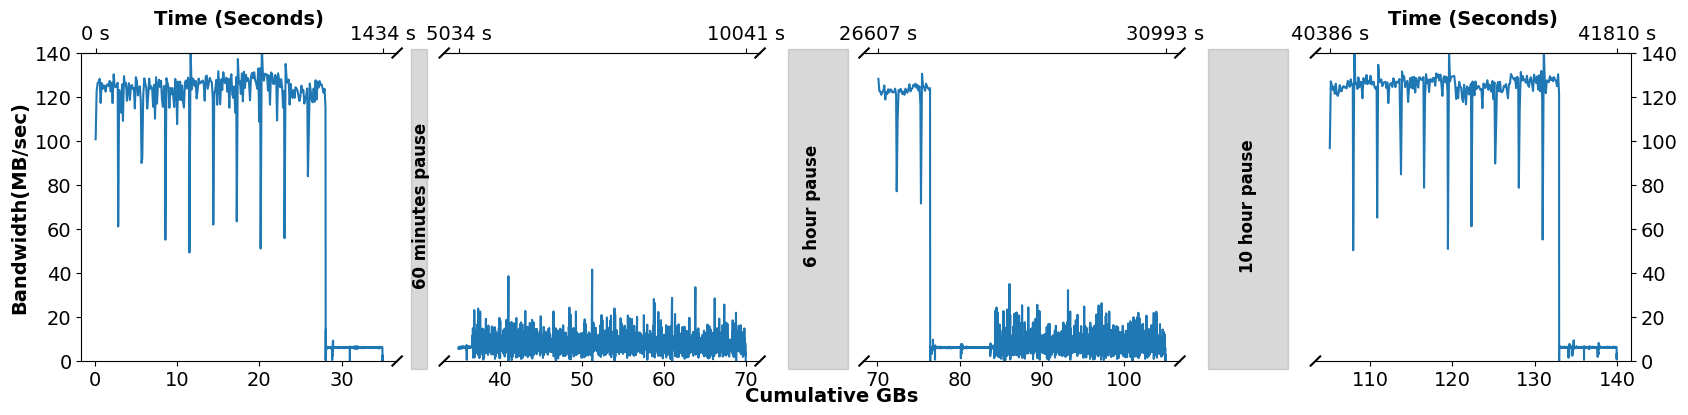

In [37]:

from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

# Create the main plot
#fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4), layout='constrained', sharey=True)
# Create a figure and GridSpec
fig = plt.figure(figsize=(20, 5))
gs = gridspec.GridSpec(1, 7, width_ratios=[1, 0.02, 1, 0.2, 1, 0.3, 1], wspace=0.1)  # Adjust width_ratios and wspace as needed

# Create subplots
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[4])
ax4 = plt.subplot(gs[6])

# Set labels for the primary x-axis and y-axis
#ax1.set_xlabel("Cumulative GBs")
fig.supxlabel("Cumulative GBs", fontsize=14, weight="bold", y=0)
ax1.set_ylabel("Bandwidth(MB/sec)", fontsize=14, weight="bold")
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

# Optionally, remove the right y-ticks
ax1.yaxis.set_ticks_position('left')  # Only show ticks on the left side
ax1.spines['right'].set_visible(False)

ax4.yaxis.set_ticks_position('right')  # Only show ticks on the right side
ax4.spines['left'].set_visible(False)
ax4.tick_params(axis='y', labelsize=14)

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim(0, 140)

# Customize spines and ticks
for ax in [ax2, ax3]:
    # Hide all spines and ticks initially
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='both', left=False, right=False, labelleft=False, labelright=False)


# Map the ticks from the primary axis (cumulative_gbs) to the corresponding time values
tick_locations = np.linspace(df_grouped1['cumulative_gb'].min(), df_grouped1['cumulative_gb'].max(), 2)  # Choose tick locations (e.g., 5 ticks)
corresponding_time_values1 = np.interp(tick_locations, df_grouped1['cumulative_gb'], df_grouped1.index)  # Interpolate corresponding time values

secax1 = ax1.secondary_xaxis('top')
#Set the ticks and their labels on the secondary axis
secax1.set_xticks(tick_locations)
secax1.set_xticklabels([f"{int(val)} s" for val in corresponding_time_values1])  # Format as seconds
df_grouped1['seconds'] = pd.to_numeric(df_grouped1.index)
df_grouped2['seconds'] = pd.to_numeric(df_grouped2.index)
maxindex = df_grouped1.iloc[-1].seconds + df_grouped2.iloc[-1].seconds
secax1.set_xlim(0, maxindex)
secax1.spines['top'].set_linestyle((0, (1, 1)))  # Dotted pattern (0, (1, 1))
secax1.spines['top'].set_color('green')          # Set the color to green
secax1.tick_params(axis='x', labelsize=14)     # Set the ticks color to green


 # Choose tick locations (e.g., 5 ticks)
tick_locations = np.linspace(df_grouped2['cumulative_gb'].min(), df_grouped2['cumulative_gb'].max(), 2)
corresponding_time_values1 = np.interp(tick_locations, df_grouped2['cumulative_gb'], df_grouped2.time)  # Interpolate corresponding time values
secax2 = ax2.secondary_xaxis('top')
# Set the ticks and 
secax2.spines['top'].set_linestyle((0, (1, 1)))  # Dotted pattern (0, (1, 1))
secax2.spines['top'].set_color('green')          # Set the color to green
secax2.tick_params(axis='x' , labelsize=14)     # Set the ticks color to greentheir labels on the secondary axis
secax2.set_xticks(tick_locations)
secax2.set_xticklabels([f"{int(val)} s" for val in corresponding_time_values1])  # Format as seconds

tick_locations = np.linspace(df_grouped3['cumulative_gb'].min(), df_grouped3['cumulative_gb'].max(), 2)  # Choose tick locations (e.g., 5 ticks)
corresponding_time_values1 = np.interp(tick_locations, df_grouped3['cumulative_gb'], df_grouped3.time)  # Interpolate corresponding time values
secax3 = ax3.secondary_xaxis('top')
# Set the ticks and 
secax3.spines['top'].set_linestyle((0, (1, 1)))  # Dotted pattern (0, (1, 1))
secax3.spines['top'].set_color('green')          # Set the color to green
secax3.tick_params(axis='x', labelsize=14)     # Set the ticks color to greentheir labels on the secondary axis
secax3.set_xticks(tick_locations)
secax3.set_xticklabels([f"{int(val)} s" for val in corresponding_time_values1])  # Format as seconds


tick_locations = np.linspace(df_grouped5['cumulative_gb'].min(), df_grouped5['cumulative_gb'].max(), 2)  # Choose tick locations (e.g., 5 ticks)
corresponding_time_values1 = np.interp(tick_locations, df_grouped5['cumulative_gb'], df_grouped5.time)  # Interpolate corresponding time values
secax5 = ax4.secondary_xaxis('top')
# Set the ticks and 
secax5.spines['top'].set_linestyle((0, (1, 1)))  # Dotted pattern (0, (1, 1))
secax5.spines['top'].set_color('green')          # Set the color to green
secax5.tick_params(axis='x', labelsize=14)     # Set the ticks color to greentheir labels on the secondary axis
secax5.set_xticks(tick_locations)
secax5.set_xticklabels([f"{int(val)} s" for val in corresponding_time_values1])  # Format as seconds

ax2.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='x', labelsize=14)

#secax2.sharex(secax1)
ax1.plot(df_grouped1['cumulative_gb'], df_grouped1['data_written_bytes'], label="Run1")
#df_grouped2['cumulative_gb'] = df_grouped2['cumulative_gb'] + df_grouped1.iloc[-1].cumulative_gb
ax2.plot(df_grouped2['cumulative_gb'], df_grouped2['data_written_bytes'], label="Run2")
ax3.plot(df_grouped3['cumulative_gb'], df_grouped3['data_written_bytes'], label="Run3")
ax4.plot(df_grouped5['cumulative_gb'], df_grouped5['data_written_bytes'], label="Run3")

# Add diagonal lines to indicate the break
d = .015  # size of the diagonal lines
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)
ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)


kwargs.update(transform=ax2.transAxes)  # switch to the right axis
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
ax2.plot((1-d, 1+d), (1-d, 1+d), **kwargs)
ax2.plot((1-d, 1+d), (-d, +d), **kwargs)

kwargs.update(transform=ax3.transAxes)  # switch to the right axis
ax3.plot((-d, +d), (-d, +d), **kwargs)
ax3.plot((-d, +d), (1-d, 1+d), **kwargs)
ax3.plot((1-d, 1+d), (1-d, 1+d), **kwargs)
ax3.plot((1-d, 1+d), (-d, +d), **kwargs)

kwargs.update(transform=ax4.transAxes)  # switch to the right axis
ax4.plot((-d, +d), (-d, +d), **kwargs)
ax4.plot((-d, +d), (1-d, 1+d), **kwargs)


# Add a rectangle exactly between the diagonal lines
mid_x = (ax1.get_position().x1 + ax2.get_position().x0) / 2  # Midpoint between the subplots
rect1 = plt.Rectangle((mid_x-0.005, 0.09), 0.008, 0.8, transform=fig.transFigure, color="gray", alpha=0.3)
fig.patches.append(rect1)
# Add text inside the rectangle
fig.text(mid_x, 0.5, "60 minutes pause", ha="center", va="center", fontsize=12, color="black", weight="bold", rotation=90)


mid_x = (ax2.get_position().x1 + ax3.get_position().x0) / 2  # Midpoint between the subplots
rect2 = Rectangle((mid_x-0.012, 0.09), 0.03, 0.8, transform=fig.transFigure, color="gray", alpha=0.3)
fig.patches.append(rect2)
# Add text inside the rectangle
fig.text(mid_x, 0.5, "6 hour pause", ha="center", va="center", fontsize=12, color="black", weight="bold", rotation=90)


mid_x = (ax3.get_position().x1 + ax4.get_position().x0) / 2  # Midpoint between the subplots
rect3 = Rectangle((mid_x - 0.02, 0.09), 0.04, 0.8, transform=fig.transFigure, color="gray", alpha=0.3)
fig.patches.append(rect3)
# Add text inside the rectangle
fig.text(mid_x, 0.5, "10 hour pause", ha="center", va="center", fontsize=12, color="black", weight="bold", rotation=90)

secax1.set_xlabel("Time (Seconds)", labelpad=0, loc='center', fontsize=14, weight="bold")
#secax2.set_xlabel("Time (Seconds)", labelpad=0, loc='center', fontsize=11)
#secax3.set_xlabel("Time (Seconds)", labelpad=0, loc='center', fontsize=11)
secax5.set_xlabel("Time (Seconds)", labelpad=0, loc='center', fontsize=14, weight="bold")

#plt.tight_layout(rect=[0, 0, 1, 0.3])  # Leave space for the suptitle
#fig.suptitle("Asynchronous 1MB uniform random writes to DM-Hybrid with pauses to elucidate cache cleaning", fontsize=14)
plt.savefig("/home/surbhi/Downloads/cache-pause.pdf", format="pdf", bbox_inches='tight')# Add a rectangle exactly between the diagonal lines
plt.show()
